# K-Medoids++ Algorithm

Guilherme Franca <guifranca@gmail.com>, 08/15/2016

Abstract: We implement K-Medoids algorithm and compare it to $K$-Means. We use the same idea as $K$-means++ for initialization.

This algorithm is very similar to $K$-means with the exception that instead of getting a mean of the points inside the cluster, we pick the *medoid*. A medoid is a data point whose average dissimilarity to all objects in the cluster is minimal. In other words, it's the closest data point to the center of the data in that cluster.

Compared to $K$-means it is more robust to noise and to outliers.

The algorithm is described as follows. Consider a distance function $\mathcal{V}(x_i, x_j)$
between data points $X = \{x_i\}_{i=1}^N$. Let
$$
z_{nk} = \begin{cases}
1 & \mbox{if $x_n \in C_k$} \\
0 & \mbox{otherwise}
\end{cases}
$$
where $C_k$, $k=1,\dotsc,K$, represents the $k$th cluster. We want to minimize the cost function
$$
J = \dfrac{1}{2}\sum_{n=1}^N \sum_{k=1}^K z_{nk} \mathcal{V}(x_n, m_k)
$$
where $m_k$ is the $k$th medoid of cluster $k$. We do this as follows:
    
1. Given a data set $X$ compute the distance matrix $D \in \mathbb{R}^{N \times N}$ between data points.
2. Initialize medoids $\{m_1, \dotsc, m_K\}$.
3. $Z$-update: 
$$
z_{nk} = \begin{cases} 
1 & \mbox{ if $k = \mbox{argmin}_{j} \mathcal{V}(x_n, m_j)$ } \\ 
0 & \mbox{otherwise}
\end{cases}
$$

4. $M$-update:
$$
m_k = \mbox{argmin}_{x_l \in C_k}\left\{ \dfrac{1}{n_k} \sum_{x_i \in C_k} \mathcal{V}(x_l,x_i)\right\}
$$
5. Repeat 3 and 4 until convergence.

Notice that we just need to compute distance between data points, thus we can compute a distance matrix $D_{ij} = \mathcal{V}(x_i, x_j)$ and implement this algorithm just working with the indices of the data points.

Moreover, we can choose the initialization step 2 in the same way as $K$-means++. 

This implementation can be found on file **kmedoids.py**.
    

## Comparison $K$-Medoids and $K$-Means for Gaussian Clusters

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn import datasets

from kmedoids import euclidean
from kmedoids import kmedoids
from kmeans import kmeans

In [60]:
# artificial data from normal distribution
mean = np.array([0,0])
cov = np.array([[4,0], [0,1]])
data1 = np.random.multivariate_normal(mean, cov, 200)
mean = np.array([3,5])
cov = np.array([[1,0.8], [0.8,2]])
data2 = np.random.multivariate_normal(mean, cov, 200)
mean = np.array([-2,3])
cov = np.array([[0.5,0], [0,0.5]])
data3 = np.random.multivariate_normal(mean, cov, 200)
data = np.concatenate((data1, data2, data3))

In [61]:
K=3
D = euclidean(data)
J, M = kmedoids(K, D)

In [62]:
K=3
JJ, MM = kmeans(K, data)

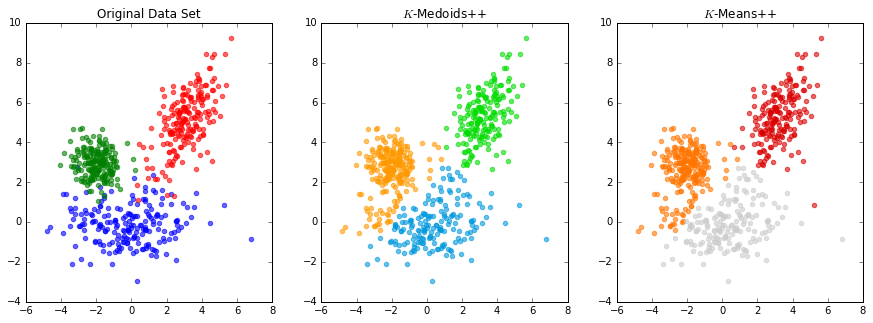

In [63]:
%matplotlib inline

fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(131)
ax.scatter(data1[:,0], data1[:,1], color='b', alpha=.6)
ax.scatter(data2[:,0], data2[:,1], color='r', alpha=.6)
ax.scatter(data3[:,0], data3[:,1], color='g', alpha=.6)
ax.set_title('Original Data Set')

ax = fig.add_subplot(132)
cc = cm.spectral(np.linspace(0.3,0.8,K))
for k in range(K):
    idx = np.where(J==k)
    ax.scatter(data[:,0][idx], data[:,1][idx], color=cc[k], alpha=.6)
ax.set_title('$K$-Medoids++')
    
ax = fig.add_subplot(133)
cc = cm.spectral(np.linspace(0.81,1,K))
for k in range(K):
    idx = np.where(JJ==k)
    ax.scatter(data[:,0][idx], data[:,1][idx], color=cc[k], alpha=.6)
ax.set_title('$K$-Means++')

## Comparing $K$-Medoids and $K$-Means for Iris Dataset

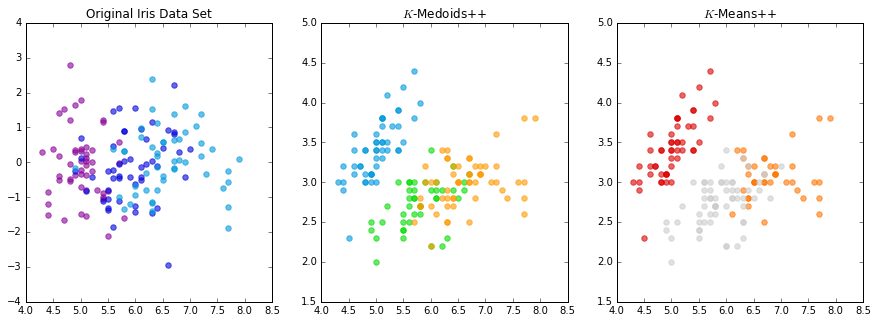

In [64]:
# using the iris data set

iris = datasets.load_iris()
iris_data = iris.data
iris_label = iris.target

K = 3
J, M = kmedoids(K, euclidean(iris_data))
JJ, MM = kmeans(K, iris_data)


fig = plt.figure(figsize=(15,5))

s = 30 #marker size
ax = fig.add_subplot(131)
cc = cm.spectral(np.linspace(0.1, 0.3, K))
for k in range(K):
    idx = np.where(iris_label==k)
    ax.scatter(iris_data[:,0][idx], data1[:,1][idx], color=cc[k], alpha=.6, s=s)
ax.set_title('Original Iris Data Set')

ax = fig.add_subplot(132)
cc = cm.spectral(np.linspace(0.3,0.8,K))
for k in range(K):
    idx = np.where(J==k)
    ax.scatter(iris_data[:,0][idx], iris_data[:,1][idx], color=cc[k], alpha=.6, s=s)
ax.set_title('$K$-Medoids++')
    
ax = fig.add_subplot(133)
cc = cm.spectral(np.linspace(0.81,1,K))
for k in range(K):
    idx = np.where(JJ==k)
    ax.scatter(iris_data[:,0][idx], iris_data[:,1][idx], color=cc[k], alpha=.6, s=s)
ax.set_title('$K$-Means++')

## Comparing $K$-Medoids and $K$-Means for Digits Dataset

In [65]:
# now let us use the digits data set

digits = datasets.load_digits()
images = digits.images
print images.shape

(1797, 8, 8)


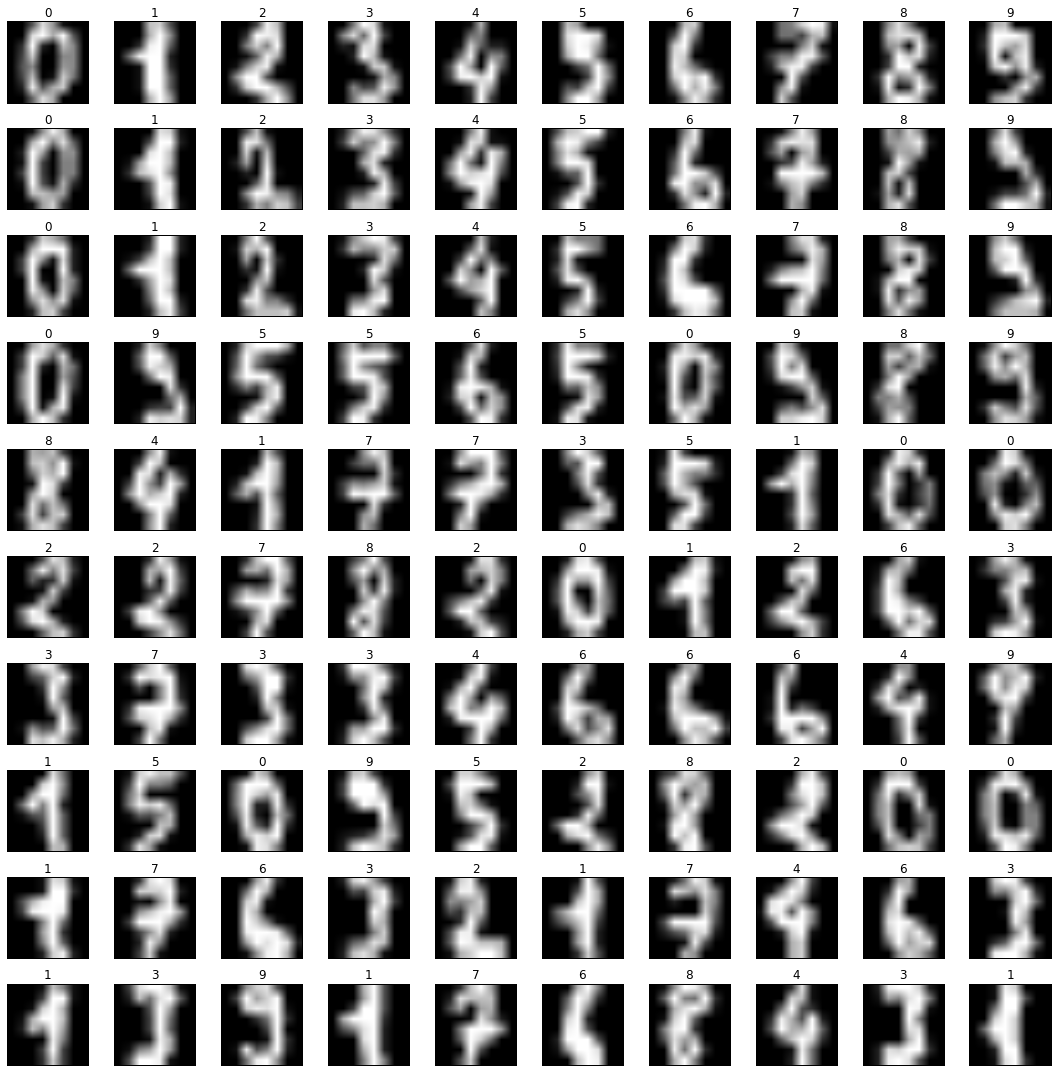

In [73]:
# showing a sample of the figures
fig = plt.figure(figsize=(15,15))
for i, img in enumerate(images[:100]):
    ax = fig.add_subplot(10, 10, i+1)
    ax.imshow(img, cmap=cm.gray)
    ax.set_title("%i" % digits.target[i])
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()

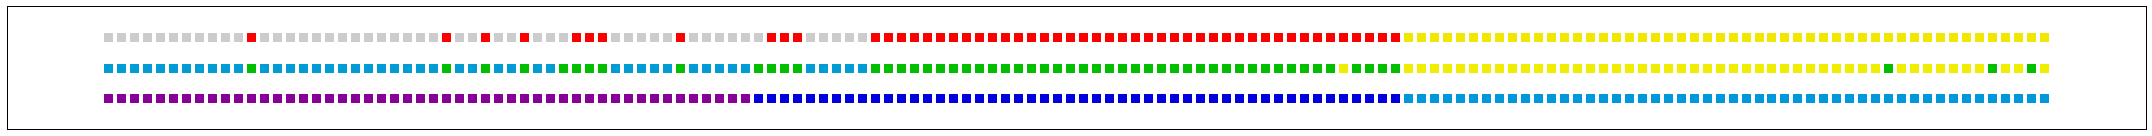

In [132]:
# picking some digits
n = [50, 50, 50]
d = [1, 2, 3]
labels = np.concatenate([[i]*x for i, x in enumerate(n)])

data = np.concatenate([images[np.where(digits.target==i)][:m].reshape((m, 64)) 
                       for i, m in zip(d, n)])

# just to plot points and visualize data
coords = np.array([i for i in range(len(data))])

J, M = kmedoids(len(n), euclidean(data))
JJ, MM = kmeans(len(n), data)

fig = plt.figure(figsize=(30,2))
ax = fig.add_subplot(111)
ax.set_xticks([])
ax.set_yticks([])
cc = cm.spectral(np.linspace(0.1, 0.3, len(n)))
s = 50
for k in range(len(n)):
    idx = np.where(labels==k)[0]
    ax.scatter(coords[idx], [0]*len(idx), color=cc[k], s=s, marker='s')

cc = cm.spectral(np.linspace(0.31, 0.7, len(n)))
for k in range(len(n)):
    idx = np.where(J==k)[0]
    ax.scatter(coords[idx], [1]*len(idx), color=cc[k], s=s, marker='s')

cc = cm.spectral(np.linspace(0.71, 1, len(n)))
for k in range(len(n)):
    idx = np.where(JJ==k)[0]
    ax.scatter(coords[idx], [2]*len(idx), color=cc[k], s=s, marker='s')

ax.set_xticks([])
ax.set_yticks([])
ax.set_ylim(-1, 3)
fig.tight_layout()


The above figure show each a colored dot for each digit category. The bottom dots are the true digits, the second line of dots are the digits clustered by $K$-medoids++, and the top line of dots using $K$-means++.